In [121]:
using JuMP
using Gurobi, Ipopt
using Plots
using DataFrames
using CSV
using DelimitedFiles

In [3]:
function bicycle_model(state, input, dt, L)
    x, y, psi, v = state
    delta, a = input

    x_new = x + v * cos(psi) * dt
    y_new = y + v * sin(psi) * dt
    psi_new = psi + (v * tan(delta) / L) * dt
    v_new = v + a * dt

    return [x_new, y_new, psi_new, v_new]
end


bicycle_model (generic function with 1 method)

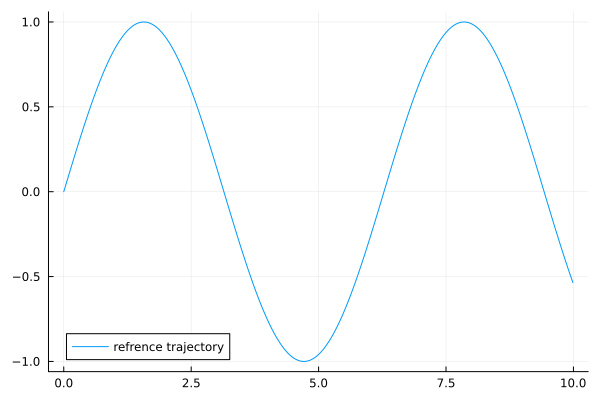

In [132]:
function reference_trajectory(t)
    r = 2
    x_ref = t
    y_ref = sin(t)
    psi_ref = atan(cos(t))
    v_ref = 1.0
    return [x_ref, y_ref, psi_ref, v_ref]
end

t = range(0,step=0.01,length=1000)
ref_traj = [reference_trajectory(t) for t in t]
ref_traj
ref_x = [r[1] for r in ref_traj]
ref_y = [r[2] for r in ref_traj]
ref_psi =  [r[3] for r in ref_traj]
ref_v = [r[4] for r in ref_traj]
plot(ref_x,ref_y, label="refrence trajectory")

In [180]:
data = DataFrame(CSV.File("data\\Sin_Traj.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = size(data)[1]
plot(ref_x,ref_y, label="refrence trajectory")
print(N)

210

In [181]:
function mpc_solver(state, T, dt, L, Q, R, step, u_prev, reference_trajectory)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, x[1:T+1])
    @variable(model, y[1:T+1])
    @variable(model, psi[1:T+1])
    @variable(model, v[1:T+1])
    @variable(model, delta[1:T])
    @variable(model, a[1:T])
    
    # warm start up from previous output
    set_start_value(delta[1], u_prev[1])
    set_start_value(a[1], u_prev[2])

    #closest_refs = [find_closest_ref(x[i],y[i]) for i in 1:N]
   
    #idx = (step+i-1)%N
    @NLexpression(model, err, sum( (Q[1]*(x[i] - ref_traj[(step+i-1)%N + 1,1])^2 + Q[2]*(y[i] - ref_traj[(step+i-1)%N + 1,2])^2
                    + Q[3]*(psi[i] - ref_traj[(step+i-1)%N + 1,3])^2 + Q[4]*(v[i] - ref_traj[(step+i-1)%N + 1,4]))^2 for i in 1:T))

    @NLexpression(model, input, sum( (R[1]*delta[i]^2 + R[2]*a[i]^2) for i in 1:T))

    @NLobjective(model, Min, err + input)

    # Bicycle model constraint
    for i in 1:T-1
        @NLconstraint(model, x[i+1] == x[i] + v[i] * cos(psi[i]) * dt) 
        @NLconstraint(model, y[i+1] == y[i] + v[i] * sin(psi[i]) * dt)  
        @NLconstraint(model, psi[i+1] == psi[i] + (v[i] * tan(delta[i]) / L) * dt)
        @constraint(model, v[i+1] ==  v[i] + a[i]*dt)
        #@constraint(model, v[i+1] ==  0.5)
    end

    #@constraint(model, vel[i in 1:N], v)
    
    # set initial constraint
    @constraint(model, x[1]   == state[1])
    @constraint(model, y[1]   == state[2])
    @constraint(model, psi[1] == state[3])
    @constraint(model, v[1]   == state[4])
    
    # control input constraints
    @constraint(model, a_up[i in 1:T], a[i] <= 25)
    @constraint(model, a_lb[i in 1:T], a[i] >= -25)
    
    @constraint(model, delta_up[i in 1:T], delta[i] <= pi/6)
    @constraint(model, delta_lb[i in 1:T], delta[i] >= -pi/6)

    optimize!(model)
    return value.(delta[1]), value.(a[1]), objective_value(model)
end

mpc_solver (generic function with 1 method)

In [182]:
T = 50
dt = 0.01
L = 0.2
Q = [50.0, 50.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0.7854, 1.0]
num_steps = N

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], reference_trajectory)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


Step: 1, State: [0.007071054825112363, 0.007071080798594736, 0.8142675137491905, 1.2500000024984543], Control Input: (0.5235987799439364, 25.00000024984542)
Step: 2, State: [0.015651070572359736, 0.0161613684949001, 0.8503519053579545, 1.5000000049969229], Control Input: (0.5235987721457576, 25.000000249846863)
Step: 3, State: [0.02554685148670415, 0.027434057685788563, 0.8764165253323494, 1.7500000074954014], Control Input: (0.3344711336355173, 25.000000249847854)
Step: 4, State: [0.036745258520486934, 0.04088194534627691, 0.8736210088455044, 2.0000000099831974], Control Input: (-0.03193789608471043, 25.00000024877961)
Step: 5, State: [0.04958635226584662, 0.056215122297455795, 0.870854971042471, 2.25000001247055], Control Input: (-0.027653326842669513, 25.000000248735248)
Step: 6, State: [0.0640802410782239, 0.07342492161953368, 0.8681187162929647, 2.5000000149690322], Control Input: (-0.02431746987898798, 25.000000249848252)
Step: 7, State: [0.08023682429681281, 0.09250278382118844,

Step: 55, State: [3.1664528488123707, 2.824680581568807, 0.5203380252372266, 14.750000137057963], Control Input: (-0.02653862843223357, 25.000000245613492)
Step: 56, State: [3.2944313978826787, 2.898013666749916, 0.5000087656039093, 15.000000139506895], Control Input: (-0.027558119094640347, 25.0000002448931)
Step: 57, State: [3.4260681530173036, 2.969928652087796, 0.47852826459573394, 15.250000141947131], Control Input: (-0.028632840399329174, 25.000000244023635)
Step: 58, State: [3.561438375025718, 3.040150823987641, 0.45582640510777117, 15.500000144376825], Control Input: (-0.029764137694669138, 25.00000024296935)
Step: 59, State: [3.7006124961981355, 3.1083825207528055, 0.43182938612060784, 15.750000146793665], Control Input: (-0.03095400519056399, 25.00000024168396)
Step: 60, State: [3.8436542513337306, 3.1743014615067993, 0.4064592172533397, 16.000000149194744], Control Input: (-0.032204948648178806, 25.000000240107912)
Step: 61, State: [3.990618486282918, 3.2375589837727183, 0.3

Step: 108, State: [11.016578553920803, -0.8084506733489848, -0.972269368490907, 17.66006201334803], Control Input: (0.002700262942705963, -13.236230653154744)
Step: 109, State: [11.11607995389862, -0.9543521827105548, -0.9694413483711246, 17.527116373405], Control Input: (0.0032027185955001833, -13.294563994302603)
Step: 110, State: [11.215241414232558, -1.0988754874787783, -0.9661899092173528, 17.392942281500016], Control Input: (0.0037101644850805952, -13.417409190498537)
Step: 111, State: [11.314109561370103, -1.2419717264312677, -0.9625140474480696, 17.25693500816668], Control Input: (0.004226817773320546, -13.600727333333882)
Step: 112, State: [11.412725815985153, -1.3835874561836803, -0.9584099793576643, 17.118539425378863], Control Input: (0.0047563917222615115, -13.83955827878142)
Step: 113, State: [11.51112691108301, -1.5236648051354913, -0.9538715608776034, 16.97725755731025], Control Input: (0.0053022934208313485, -14.128186806861283)
Step: 114, State: [11.6093453628778, -1.

Step: 160, State: [16.245639517301775, -4.957482508381081, 0.2732023029805488, 11.019430313574816], Control Input: (0.5235881532721026, 6.068929898393565)
Step: 161, State: [16.351746912231974, -4.927750283696403, 0.5636408743806509, 11.269430316067979], Control Input: (0.4851223468057307, 25.0000002493163)
Step: 162, State: [16.447009155425345, -4.867541389115633, 0.833419591403102, 11.519430318564403], Control Input: (0.4465277027626774, 25.000000249642483)
Step: 163, State: [16.524459860326246, -4.782270551212047, 1.0585657611309693, 11.769430321061925], Control Input: (0.3726353675345139, 25.000000249752155)
Step: 164, State: [16.582144515258104, -4.679681908596865, 1.263721539151221, 12.019430323560002], Control Input: (0.3354491923063741, 25.00000024980765)
Step: 165, State: [16.618475834477902, -4.565110071856589, 1.4486120720935545, 12.269430326058416], Control Input: (0.2984627845413936, 25.000000249841456)
Step: 166, State: [16.633429873448154, -4.4433304809101735, 1.61022706

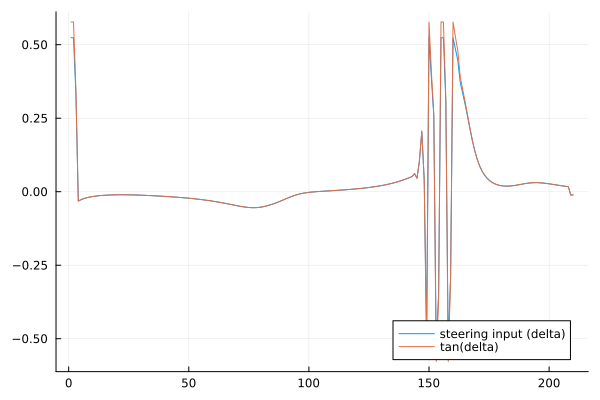

In [183]:
plot(1:num_steps, [control_mat[:,1], tan.(control_mat[:,1])], label=["steering input (delta)" "tan(delta)"])

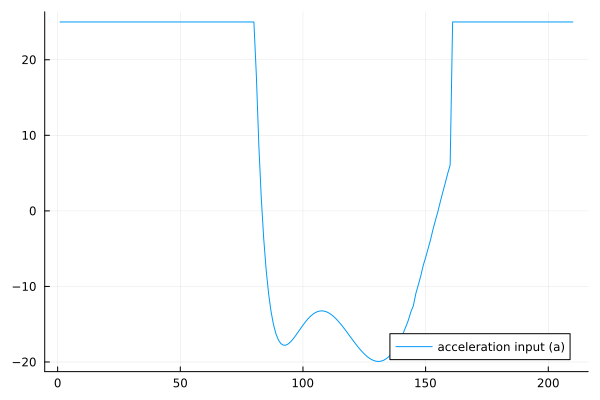

In [184]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)")

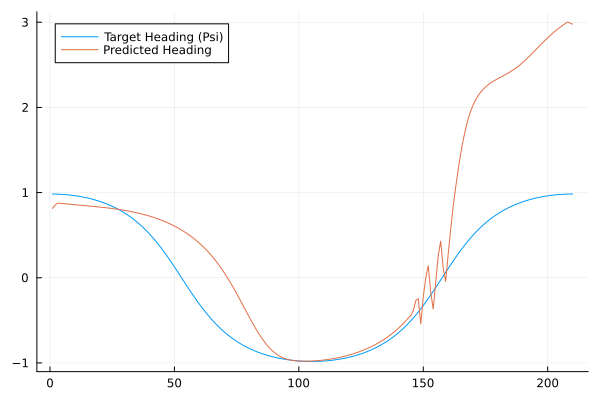

In [185]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Target Heading (Psi)" "Predicted Heading"])

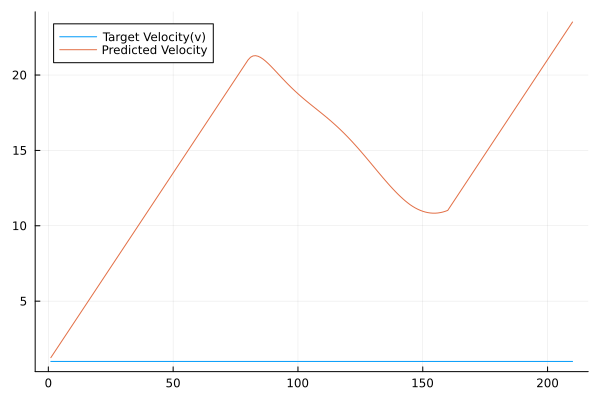

In [186]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Target Velocity(v)" "Predicted Velocity"])

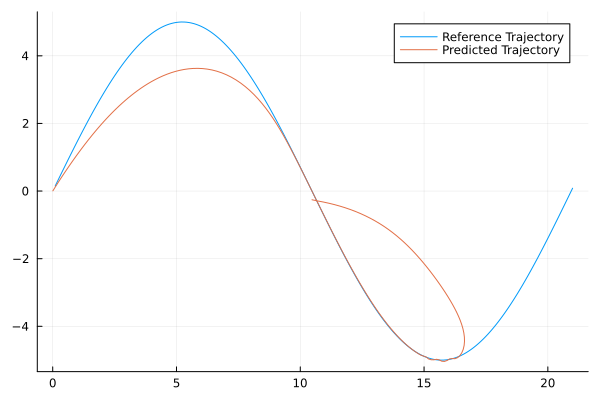

In [187]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory")
plot!(x,y, label="Predicted Trajectory")

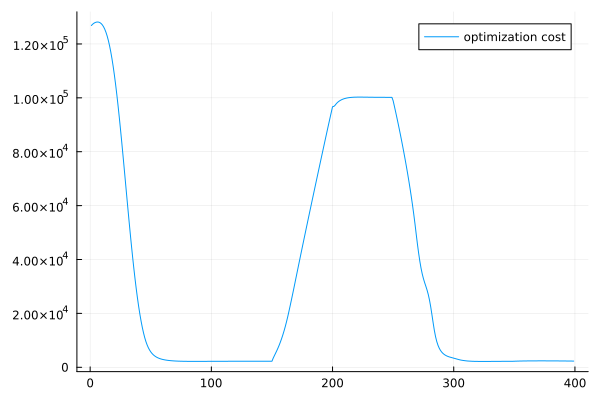

In [178]:
plot(1:num_steps, err_vec, label = "optimization cost")

In [275]:
x

100-element Vector{Float64}:
 0.01
 0.02250000002488057
 0.037500000074434395
 0.05500000014885236
 0.07500000024805203
 0.09750000037201596
 0.1225000005209153
 0.15000000069462438
 0.1800000008932597
 0.21250000111681616
 0.24750000136501327
 0.2850000016381344
 0.3250000019359258
 ⋮
 6.439408312652798
 6.546622050330482
 6.65633578803312
 6.768549525760713
 6.883263263513281
 7.000477001290384
 7.115190739042566
 7.232404476819706
 7.3471182145718625
 7.4593319522991
 7.569045690001368
 7.676259427678644

In [86]:
400*0.01

4.0